# NutriChat: Building a Local RAG Pipeline from Scratch

## Project Overview

Welcome to NutriChat, our project to build a Retrieval Augmented Generation (RAG) pipeline from the ground up! This Jupyter notebook documents our journey in creating a system that can intelligently interact with PDF documents using a Large Language Model (LLM).

### Project Goals

1. Develop a RAG pipeline that runs on a local GPU
2. Enable querying of PDF documents with natural language
3. Generate accurate responses using an LLM
4. Gain deep insights into the RAG process by building from scratch

### Why Build from Scratch?

While frameworks like LlamaIndex and LangChain offer similar functionality, our approach allows for:
- In-depth understanding of each component
- Full customization capabilities
- Flexibility to optimize for specific use cases

## Project Roadmap

Our NutriChat pipeline will be built in two major phases:

### Phase 1: Document Preprocessing and Embedding Creation

1. Import and parse PDF document
2. Text Preprocessing (Analysis, cleaning, formatting, chunking)
3. Generate embeddings for text chunks
4. Store embeddings for future use

### Phase 2: Search and Answer Generation

1. Implement vector search for relevant text retrieval
2. Design prompt engineering for context integration
3. Generate responses using LLM
4. Refine and optimize the query-answer process

## Visual Workflow

The following diagram illustrates our RAG pipeline, inspired by NVIDIA's local RAG workflow:

<p align="center">
  <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/rag-pipeline-ingest-query-flow-b-2048x960.png" width="800" alt="flowchart of a local RAG workflow" />
</p>


## Phase 1: Document Processing and Embedding Creation

### Ingredients

- PDF Document: ["Human Nutrition: 2020 Edition"](https://pressbooks.oer.hawaii.edu/humannutrition2/) (our chosen nutrition textbook)
- Embedding Model: To be selected based on performance and compatibility

### Step 1: Importing the PDF Document

For our PDF parsing needs, we'll be using [PyMuPDF](https://github.com/pymupdf/pymupdf), a robust library for handling PDF files in Python.


In [1]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [2]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm 

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random
# Now let's get a random sample of the pages.
random.sample(pages_and_texts, k=3)

[{'page_number': 701,
  'page_char_count': 1495,
  'page_word_count': 323,
  'page_sentence_count_raw': 1,
  'page_token_count': 373.75,
  'text': 'Micronutrient Sources  Recommended  Intakes for  adults  Major Functions  Deficiency  diseases and  symptoms  G ris de Iron  Red meat,  egg yolks,  dark leafy  vegetables,  dried fruit,  iron-fortified  foods  8-18 mg/day  Assists in energy  production, DNA  synthesis required  for red blood cell  function  Anemia:  fatigue,  paleness,  faster heart  rate  In pr ch ad w pr w at ve Copper  Nuts, seeds,  whole grains,  seafood  900 mcg/day  Assists in energy  production, iron  metabolism  Anemia:  fatigue,  paleness,  faster heart  rate  Th co ex zi su Zinc  Oysters,  wheat germ,  pumpkin  seeds,  squash,,  beans,  sesame  seeds, tahini,  beef, lamb  8-11 mg/day  Assists in energy  production, protein,  RNA and DNA  synthesis; required  for  hemoglobinsynthesis  Growth  retardation in  children, hair  loss, diarrhea,  skin sores,  loss of  ap

### Step 2: Text Analysis 

Exploratory Data Analysis (EDA)
- Before we dive into embedding, it's crucial to understand the characteristics of our text data. 
- Let's perform a rough exploratory data analysis to get insights into the size of the texts we're working with.

Why EDA is Important

- **Embedding Model Compatibility**: Many embedding models have input size limitations. For example, the [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model from `sentence-transformers` has a maximum input size of 384 tokens.

- **Optimal Text Splitting**: Understanding text sizes helps in determining the best strategy for splitting our text into manageable chunks.

- **Information Preservation**: Texts exceeding the token limit (e.g., 384 tokens) may lose information when embedded, as they'll be automatically truncated.

Token to Text Ratio
- 1 token ≈ 4 characters ≈ 0.75 words

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


### Initial Findings

- Our analysis shows that the average token count per page is 287. 
- This means we could potentially embed an average whole page with the all-mpnet-base-v2 model, which has an input capacity of 384 tokens.

### Step 2: Text Processing - Sentence Splitting

The next step in our pipeline is to process the text further by splitting pages into sentences. This approach offers several benefits for our RAG system.

#### Why Split into Sentences?

1. **Manageability**: Easier to handle than large blocks of text, especially for densely packed pages.
2. **Precision**: Allows for more specific retrieval and analysis within the RAG pipeline.
3. **Flexibility**: Enables grouping sentences into various chunk sizes for experimentation.

#### Splitting Methods

1. **Simple Rule-Based**: Using basic string methods like `text.split(". ")`.
2. **NLP Library-Based**: Utilizing more sophisticated tools like [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

For our project, we'll use spaCy due to its robustness and advanced NLP capabilities.

> **Note:** To use spaCy, you'll need to install it. Follow the [spaCy installation instructions](https://spacy.io/usage) for your environment.

In [6]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [7]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [8]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 280,
  'page_char_count': 1992,
  'page_word_count': 320,
  'page_sentence_count_raw': 20,
  'page_token_count': 498.0,
  'text': 'about their safety. The health concerns of sugar substitutes  originally  stemmed  from  scientific  studies,  which  were  misinterpreted by both scientists and the public.  In the early 1970s scientific studies were published that  demonstrated that high doses of saccharin caused bladder tumors  in rats. This information fueled the still-ongoing debate of the  health consequences of all artificial sweeteners. In actuality, the  results from the early studies were completely irrelevant to humans.  The large doses (2.5 percent of diet) of saccharine caused a pellet  to form in the rat’s bladder. That pellet chronically irritated the  bladder wall, eventually resulting in tumor development. Since this  study, scientific investigation in rats, monkeys, and humans have  not found any relationship between saccharine consumption and  bladder can

In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Step 2: Chunking Our Sentences

After extracting and cleaning our text, the next crucial step is to break it down into smaller, manageable pieces. This process is known as **chunking**.

Why Chunk Text?

- **Manageability**: Easier to process and analyze similar-sized text segments.
- **Embedding Model Compatibility**: Prevents information loss by staying within the token limit of embedding models (e.g., 384 tokens for our chosen model).
- **LLM Efficiency**: Optimizes the use of the LLM's context window, considering both token limits and computational resources.

#### Our Chunking Strategy

For this project, we'll use a simple yet effective approach:

- Group sentences into chunks of 10 (this number can be adjusted as needed).
- Based on our analysis:
  - Average sentences per page: 10
  - Average tokens per page: 287
  - Estimated tokens per chunk: ~287

This strategy ensures our chunks fit comfortably within our embedding model's 384-token capacity.


In [10]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 112,
  'page_char_count': 402,
  'page_word_count': 82,
  'page_sentence_count_raw': 5,
  'page_token_count': 100.5,
  'text': '“Urine  Color” by  OpenStax  College / CC  BY 3.0  Urine volume varies considerably. The normal range is one to two  liters per day. The kidneys must produce a minimum urine volume  of about 500 mL/day to rid the body of wastes. Output below  this level may be caused by severe dehydration or renal disease  and is termed oliguria. The virtual absence of urine production is  112  |  The Urinary System',
  'sentences': ['“Urine  Color” by  OpenStax  College / CC  BY 3.0  Urine volume varies considerably.',
   'The normal range is one to two  liters per day.',
   'The kidneys must produce a minimum urine volume  of about 500 mL/day to rid the body of wastes.',
   'Output below  this level may be caused by severe dehydration or renal disease  and is termed oliguria.',
   'The virtual absence of urine production is  112  |  The Urinary System'],
  '

In [12]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


- Note the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

#### Chunking and Metadata Extraction

- We'll split our preprocessed text into chunks, with each chunk containing a specific number of sentences. 
- This approach helps maintain context while keeping the chunks at a reasonable size for embedding.


In [13]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [14]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 277,
  'sentence_chunk': 'Due to the potential health consequences of consuming too many added sugars, sugar substitutes have replaced them in many foods and beverages. Sugar substitutes may be from natural sources or artificially made. Those that are artificially made are called artificial sweeteners and must be approved by the FDA for use in foods and beverages. The artificial sweeteners approved by the FDA are saccharin, aspartame, acesulfame potassium, neotame, advantame, and sucralose. Stevia is an example of a naturally derived sugar substitute. It comes from a plant commonly known as sugarleaf Carbohydrates and Personal Diet Choices | 277',
  'chunk_char_count': 627,
  'chunk_word_count': 96,
  'chunk_token_count': 156.75}]

- We've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.
- This means we could reference a chunk of text and know its source.
- Let's get some stats about our chunks.

In [15]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


#### Analyzing and Handling Short Chunks

After preparing our data for embedding, we've noticed that some chunks have a relatively low token count. Let's investigate these shorter chunks to determine if they provide enough context or if they should be handled differently.

#### Identifying Short Chunks

We'll start by identifying chunks with less than 30 tokens, which is approximately the length of a typical sentence.

In [16]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 26.25 | Text: Snowdon W, Osborn T. (2003). Coconut: It’s role in health. Secretariat of the Pacific. 292 | Introduction
Chunk token count: 4.5 | Text: 708 | Introduction
Chunk token count: 25.25 | Text: The Polynesian Family System in Ka-‘u. Rutland, Vermont: Charles E. Tuttle Company 780 | Introduction
Chunk token count: 22.0 | Text: PART I CHAPTER 1. BASIC CONCEPTS IN NUTRITION Chapter 1. Basic Concepts in Nutrition | 1
Chunk token count: 24.75 | Text: Free radical reactions can continue unchecked unless stopped by a defense mechanism. The Atom | 461


- Upon analyzing our chunks, we've discovered that many of the shorter ones are likely headers and footers from different pages. 
- These don't offer much informational value for our RAG system. Let's filter our data to include only chunks with over 30 tokens in length.

In [17]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

- This approach will help ensure that your embeddings are based on meaningful, content-rich chunks of text, which should lead to better performance in your RAG system.

### Step 3: Embedding Text Chunks
- In this section, we'll transform our text chunks into numerical representations that machines can understand and process efficiently. Let's delve into the concept of embeddings and how we'll apply them to our project.

#### Understanding Embeddings
- An embedding is, in simple terms, "a useful numerical representation" of data. For our purposes, we'll be focusing on text embeddings.
- Key points about embeddings:
    - They convert text into numbers that machines can process.
    - Modern embeddings are learned representations, not direct mappings.
    - They capture semantic relationships between words and phrases.
    - Similar texts should have similar numerical representations.

> **Note on Tokenization:** Most modern NLP models work with "tokens" rather than whole words or single characters. For example, "hello world!" might be tokenized as `{15339: b'hello', 1917: b' world', 0: b'!'}` using Byte Pair Encoding (BPE). Popular tokenization libraries include OpenAI's `tiktoken` and Google's SentencePiece.

#### Our Embedding Goal
- We aim to convert each of our text chunks into an embedding vector - a sequence of numbers that represents the semantic content of the chunk. While these vectors won't be human-readable, they'll allow our computers to efficiently process and find patterns in the text data.

#### Implementing Embeddings
- Let's use the `sentence-transformers` library to create our embeddings. We'll use the `all-mpnet-base-v2` model, which is well-suited for general-purpose text embeddings.

In [18]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

e:\Udemy\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
e:\Udemy\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982827e-02  3.03164907e-02 -2.01217998e-02  6.86484799e-02
 -2.55256370e-02 -8.47686455e-03 -2.07202378e-04 -6.32377490e-02
  2.81606764e-02 -3.33353765e-02  3.02634127e-02  5.30721359e-02
 -5.03526852e-02  2.62288693e-02  3.33313793e-02 -4.51577418e-02
  3.63044925e-02 -1.37120439e-03 -1.20171728e-02  1.14947204e-02
  5.04510924e-02  4.70856950e-02  2.11913791e-02  5.14606722e-02
 -2.03746427e-02 -3.58889513e-02 -6.67786808e-04 -2.94393841e-02
  4.95859273e-02 -1.05639482e-02 -1.52014000e-02 -1.31760479e-03
  4.48197313e-02  1.56023651e-02  8.60379600e-07 -1.21391763e-03
 -2.37978715e-02 -9.09392722e-04  7.34485826e-03 -2.53931666e-03
  5.23370579e-02 -4.68043648e-02  1.66214816e-02  4.71579358e-02
 -4.15599607e-02  9.01979220e-04  3.60277966e-02  3.42214257e-02
  9.68226865e-02  5.94829321e-02 -1.64984390e-02 -3.51249464e-02
  5.92516968e-03 -7.07937288e-04 -2.4103

In [19]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447706e-02 -4.51075193e-03 -4.98486497e-03  6.55445009e-02
 -9.87673271e-03  2.72836164e-02  3.66426073e-02 -3.30221863e-03
  8.50078557e-03  8.24954547e-03 -2.28498131e-02  4.02430035e-02
 -5.75200245e-02  6.33691624e-02  4.43207473e-02 -4.49506715e-02
  1.25284679e-02 -2.52011809e-02 -3.55293006e-02  1.29559115e-02
  8.67022481e-03 -1.92917604e-02  3.55636328e-03  1.89505611e-02
 -1.47127938e-02 -9.39847063e-03  7.64177786e-03  9.62183718e-03
 -5.98921068e-03 -3.90168764e-02 -5.47824912e-02 -5.67458477e-03
  1.11644268e-02  4.08067405e-02  1.76319088e-06  9.15308390e-03
 -8.77256040e-03  2.39382964e-02 -2.32784450e-02  8.04999471e-02
  3.19177322e-02  5.12600411e-03 -1.47708301e-02 -1.62524991e-02
 -6.03213012e-02 -4.35689948e-02  4.51211594e-02 -1.79053564e-02
  2.63366643e-02 -3.47867012e-02 -8.89172405e-03 -5.47675304e-02
 -1.24372663e-02 -2.38606520e-02  8.33496824e-02  5.71241900e-02
  1.13328183e-02 -1.49595067e-02  9.2037

- We've now got a way to numerically represent each of our chunks.
- Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.
- **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.

In [20]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 2060 

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 3min 44s
Wall time: 1min 15s


### Step 4: Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [21]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [22]:
# Import saved file and view, And we can make sure it imports nicely by loading it.
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242303e-02 9.02281776e-02 -5.09551167e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801972e-02 3.39813866e-02 -2.06426457e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566836e-02 3.81274596e-02 -8.46855715e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49767867e-03 9.57159512e-...


## Phase 2: RAG - Search and Answer

In this phase, we'll implement the core functionality of our Retrieval Augmented Generation (RAG) system. Let's start by revisiting the concept of RAG and then dive into the implementation details.

### Understanding RAG

RAG stands for Retrieval Augmented Generation. It's a method that enhances the capabilities of Large Language Models (LLMs) by providing them with relevant information retrieved from a knowledge base. Here's a breakdown of the process:

- **Retrieval**: Search for relevant resources based on a given query.
- **Augmentation**: Enhance the LLM's prompt with retrieved information to improve accuracy.
- **Generation**: Produce a response using the augmented prompt.

#### Why RAG?

RAG addresses several key challenges in using LLMs:

- Improves factual accuracy by grounding responses in specific, retrieved information.
- Reduces hallucination (generating plausible but incorrect information).
- Provides traceability by linking generated responses to source material.

### Implementing Similarity Search

The foundation of effective RAG is similarity search, also known as semantic or vector search. This method allows us to find information based on meaning rather than exact keyword matches.

#### Similarity Search vs. Keyword Search

- **Keyword Search**: Matches exact strings (e.g., "apple" with "apple").
- **Similarity Search**: Matches concepts and meanings (e.g., "macronutrients functions" might return information about carbohydrates, lipids, and proteins, even if those exact words aren't used).

#### Example
> Query: "macronutrients function"
> 
> Top Result: "There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions."

### Implementation Steps

1. **Load Embeddings**: Import the embeddings we created in Phase 1.
2. **Prepare Data**: Convert embeddings into a suitable format (e.g., tensors) for efficient search.
3. **Implement Search**: Develop a function to perform similarity search on our embeddings.
4. **Retrieve Context**: Extract relevant text chunks based on search results.
5. **Generate Prompt**: Create a prompt that incorporates the query and retrieved context.
6. **Generate Response**: Use the LLM to produce a final answer based on the augmented prompt.

<!-- ### Phase 2: Search and Answer Generation

1. Implement vector search for relevant text retrieval
2. Design prompt engineering for context integration
3. Generate responses using LLM
4. Refine and optimize the query-answer process -->


In [23]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [24]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242303, 0.0902281776, -0.00509551167, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801972, 0.0339813866, -0.0206426457, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566836, 0.0381274596, -0.00846855715, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.00849767867, 0.00957159512, ..."


In [25]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1665e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4905e-04, -9.9662e-02,  4.9

In [26]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

e:\Udemy\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Step 1: Implementing Semantic Search

Now that our embedding model is ready, we can perform semantic searches on our textbook data. Let's walk through the process of searching for information about "macronutrients functions".

#### Steps for Semantic Search

1. Define a query string
2. Convert the query to an embedding
3. Calculate similarity scores
4. Sort and retrieve results

In [40]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "Good foods for a healthy heart."
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Good foods for a healthy heart.
Time take to get scores on 1680 embeddings: 0.00026 seconds.


torch.return_types.topk(
values=tensor([0.6755, 0.6169, 0.6108, 0.6017, 0.5669], device='cuda:0'),
indices=tensor([1577,  529, 1300, 1061,  405], device='cuda:0'))

Interpreting Similarity Search Results
Understanding `torch.topk`

We use [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) to get the highest similarity scores and their corresponding indices. This function returns a tuple:

1. **Values**: The top k highest similarity scores.
2. **Indices**: The positions of these scores in the original tensor.

These indices are crucial as they allow us to map back to our original text chunks.

Mapping Scores to Text Chunks
- To see the actual text content that matches our query, we need to use the indices returned by `torch.topk` to lookup the corresponding text chunks. Here's how we can do this:

In [41]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

In [42]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Good foods for a healthy heart.'

Results:
Score: 0.6755
Text:
It is helpful to lower sodium intake, increase consumption of dietary fiber, and
limit consumption of saturated fat, which promotes plaque formation. In
addition, it is important to replace refined starches and added sugar, which can
boost triglycerides, with whole grains, fruits, and vegetables. Eating foods
rich in omega-3 fatty acids, especially fish, using alcohol in moderation, and
opting for low or no-fat dairy products can all help reduce your cardiovascular
disease risk. Emphasizing vegetable- based sources of protein, such as beans and
legumes, can be 1102 | Threats to Health
Page number: 1102


Score: 0.6169
Text:
Choose whole-grain and high-fiber foods. Reduced risk for cardiovascular disease
has been associated with diets that are high in whole grains and fiber. Fiber
also slows down cholesterol absorption. The AHA recommends that at least half of
daily grain intake should originate from whole grains. Th

### Verifying Search Results in the Original PDF

Our semantic search has yielded impressive results, providing relevant information about macronutrient functions from a vague query. To further validate the accuracy of our system, let's verify these results by checking the original PDF source.

#### Why Verify?

1. **Accuracy Confirmation**: Ensures that our search system is correctly mapping to the right content.
2. **Context Understanding**: Allows us to see the broader context around our extracted text.
3. **Source Credibility**: Helps in citing the correct source when using this information.

#### Locating the Source in the PDF

Our search result indicates that the relevant text is on page 5 of our extracted content. However, due to the structure of our PDF, we need to adjust this number:


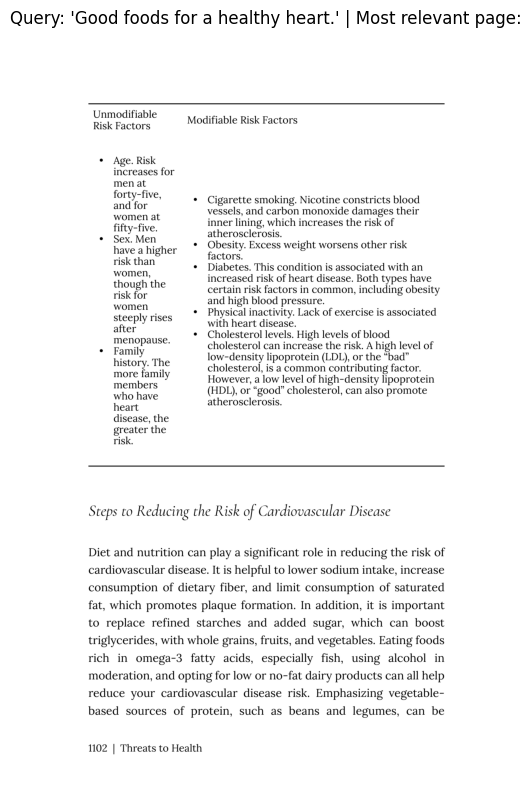

In [44]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(1102 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [45]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together score>s and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [48]:
query = "Healthy diet"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00009 seconds.


(tensor([0.6770, 0.6476, 0.6463, 0.6273, 0.6234], device='cuda:0'),
 tensor([  78, 1046,   79, 1059, 1484], device='cuda:0'))

In [49]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
Query: Healthy diet

Results:
Score: 0.6770
Achieving a Healthy Diet UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN
NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Achieving a healthy diet is a
matter of balancing the quality and quantity of food that is eaten. There are
five key factors that make up a healthful diet: 1. A diet must be adequate, by
providing sufficient amounts of each essential nutrient, as well as fiber and
adequate calories. 2. A balanced diet results when you do not consume one
nutrient at the expense of another, but rather get appropriate amounts of all
nutrients. 3. Calorie control is necessary so that the amount of energy you get
from the nutrients you consume equals the amount of energy you expend during
your day’s activities. 4. Moderation means not eating to the extremes, neither
too much nor too little. 5.
Page number: 30


Score: 0.6476
Image by Allison Calabrese / CC BY 4.0 Building a

## Selecting an LLM for Local Generation

With our retrieval pipeline in place, we now turn our attention to the generation component of our RAG system. This involves selecting and implementing a Large Language Model (LLM) that will generate responses based on the retrieved context.

### Understanding LLMs in the Context of RAG

LLMs are designed to generate text output given a text input, commonly referred to as a prompt. In our RAG system, we'll augment this prompt with:
1. The user's query
2. Relevant context retrieved from our nutrition textbook

This approach aims to generate responses that are both relevant and grounded in the specific information from our source material.

### Key Considerations for LLM Selection

When choosing an LLM for a local RAG system, two primary questions need to be addressed:

1. **Do I want it to run locally?** 
   - Running locally provides more control and privacy but may sacrifice some performance.
   
2. **If yes, how much compute power can I dedicate?**
   - This will determine the size and complexity of the model you can use.

### Cloud vs. Local LLMs

#### Cloud-based LLMs (e.g., GPT-4, Claude 3)
- Pros: Superior performance, constantly updated
- Cons: Data privacy concerns, reliance on external API, potential costs

#### Local LLMs
- Pros: Data stays on your machine, no API costs, customizable
- Cons: May have lower performance, requires significant local compute power

### Finding Suitable Local LLMs

Two excellent resources for discovering and comparing open-source LLMs:

1. [Hugging Face Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)
   - Compares various LLMs on different benchmarks

2. [TheBloke on Hugging Face](https://huggingface.co/TheBloke)
   - Offers a wide range of quantized (reduced size) LLMs

### Hardware Requirements for Local LLMs

The size of the LLM (measured in number of parameters) generally correlates with its performance. However, larger models require more GPU memory. Here's a guideline for GPU memory requirements based on model size and precision:

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|--------------------------------|-------------------|-------------------|-----------------|-----------------|
| 1B                             | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., Llama 2 7B, Gemma 7B)| ~28               | ~14               | ~7              | ~3.5            |
| 10B                            | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g., Llama 2 70B)        | ~280              | ~140              | ~70             | ~35             |
| 100B                           | ~400              | ~200              | ~100            | ~50             |
| 175B                           | ~700              | ~350              | ~175            | ~87.5           |

> **Note:** Lower precision (e.g., 8-bit instead of float16) generally reduces performance but allows for running larger models on less powerful hardware. Finding the right balance between model size, precision, and performance often requires experimentation.

### Recommended Models for Local RAG

Based on the balance of performance and hardware requirements, some good starting points for local RAG systems include:

1. **[Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b)**: A versatile model with good performance across various tasks.
2. **[Gemma 7B](https://huggingface.co/google/gemma-7b-it)**: Google's recent release, optimized for instruction following.
3. **[Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1)**: Known for strong performance despite its relatively small size.

These 7B parameter models offer a good balance of performance and resource requirements, making them suitable for many local setups.

### Next Steps

With these considerations in mind, our next steps will be:

1. Selecting a specific LLM for our NutriChat system
2. Setting up the environment to run the chosen LLM locally
3. Integrating the LLM with our retrieval pipeline
4. Developing a prompt engineering strategy to effectively utilize our retrieved context

In the next section, we'll walk through the process of implementing our chosen LLM and preparing it for integration with our RAG pipeline.

In [50]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 6 GB


In [51]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 6 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


## Loading an LLM Locally

Now that we've selected our LLM, let's walk through the process of loading it locally. For this example, we'll use the `gemma-2b-it` model, which offers a good balance of performance and resource requirements.

### Prerequisites

Before we begin, ensure you have the following:

1. A compatible GPU (e.g., NVIDIA RTX 4090 or similar)
2. [Hugging Face `transformers` library](https://huggingface.co/docs/transformers/) installed
3. [Hugging Face account](https://huggingface.co/join) with accepted terms for Gemma models
4. [Hugging Face CLI](https://huggingface.co/docs/huggingface_hub/en/quick-start#installation) installed and authenticated

> **Note:** Downloading the Gemma 2B model requires about ~5 GB of storage space and may take some time depending on your internet connection.

### Step-by-Step Loading Process

Let's break down the process of loading our LLM:

1. Set up quantization config (optional)
2. Define the model ID
3. Create a tokenizer
4. Load the LLM model
5. Enable Flash Attention 2 (if available)

In [55]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-2b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


e:\Udemy\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

e:\Udemy\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pramo\.cache\huggingface\hub\models--google--gemma-2b-it. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [57]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [58]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2106740736, 'model_mem_mb': 2009.14, 'model_mem_gb': 1.96}

- The model takes about 2 GB of spce on the GPU. 

## Generating Text with Our LLM

Now that we have our LLM loaded, let's explore how to use it to generate text. This process involves tokenizing our input, applying the appropriate chat template, and then using the model's `generate()` method to produce the output.

### Key Components

1. **Tokenizer**: Converts our text input into a format the model can understand.
2. **Chat Template**: Formats our input in the style the model was trained on.
3. **Generation**: Uses the model to produce text based on the input.

In [59]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [60]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}



e:\Udemy\simple-local-rag\venv\Lib\site-packages\transformers\models\gemma\modeling_gemma.py:561: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,   5626,   2971,   7177,  72780,    604,
          4134, 235265,   2365,    708,    573,   7920,   9719,    604,   1167,
          5999,    578,  29703, 235265,    108, 235287,   5231,  49471,  66058,
         33849,    603,   8727,    604,   4547,    578,  68808,  29703, 235269,
          3547,  44760, 235269,    578,  17839,  53186, 235265,    108, 235287,
          5231,  33690,  66058,  22904,   6572,   4134, 235269,   7154,  33398,
         48765, 2

In [61]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Our body uses carbohydrates for energy. They are the primary fuel for our cells and tissues.
* **Protein:** Protein is essential for building and repairing tissues, making enzymes, and producing hormones.
* **Fat:** Fat provides energy, helps absorb vitamins, and helps to insulate the body.

**Macronutrient Ratios:**

* **Carbohydrates:** Our bodies need around 45-65% of our total calories from carbohydrates.
* **Protein:** We need around 1.6-2.2 grams of protein per kilogram of body weight per day.
* **Fat:** We need around 20-30% of our total calories from fat.

**How Macronutrients Work Together:**

Macronutrients work together to provide the body with the energy and building blocks it needs to func

In [62]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Our body uses carbohydrates for energy. They are the primary fuel for our cells and tissues.
* **Protein:** Protein is essential for building and repairing tissues, making enzymes, and producing hormones.
* **Fat:** Fat provides energy, helps absorb vitamins, and helps to insulate the body.

**Macronutrient Ratios:**

* **Carbohydrates:** Our bodies need around 45-65% of our total calories from carbohydrates.
* **Protein:** We need around 1.6-2.2 grams of protein per kilogram of body weight per day.
* **Fat:** We need around 20-30% of our total calories from fat.

**How Macronutrients Work Together:**

Macronutrients work together to provide the body with the energy and building blocks it needs to function properly. For example:

* Carbohydrates are broken down i

In [70]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [71]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on 1680 embeddings: 0.00007 seconds.


(tensor([0.5964, 0.5766, 0.5745, 0.5707, 0.5600], device='cuda:0'),
 tensor([1548,  360,  373,  380,  379], device='cuda:0'))

## Augmenting our Prompt with Context Items

A key feature of a RAG system is its ability to enhance the LLM's knowledge with relevant information retrieved from our knowledge base. This process, known as prompt augmentation, involves incorporating the context items from our search results into the prompt we pass to our LLM.

### Understanding Prompt Augmentation

Prompt augmentation is a crucial step in the RAG pipeline:
1. It provides the LLM with specific, relevant information from our nutrition textbook.
2. It helps ground the LLM's response in factual, domain-specific knowledge.
3. It can improve the accuracy and relevance of the generated text.

In [72]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [77]:
print(prompt)

<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often assoc

In [73]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Describe the process of digestion and absorption of nutrients in the human body.
[INFO] Time taken to get scores on 1680 embeddings: 0.00007 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vit

In [74]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Describe the process of digestion and absorption of nutrients in the human body.
RAG answer:
<bos>Sure, here's a summary of the relevant passages about the process of digestion and absorption of nutrients in the human body:

**Step 1: Recognition of the need for nutrients**

- The digestive system is activated when a person feels hungry due to a decrease in blood sugar levels.
- The mouth, eyes, and nose are involved in the sense of hunger and provide sensory cues to indicate the need to eat.

**Step 2: The digestive process**

- The digestive system is composed of several organs that work together to break down food molecules into smaller ones that can be absorbed by the body.
- The digestive process occurs in two levels: mechanical and chemical.
- Mechanical digestion involves physical actions and movements, while chemical digestion involves the breakdown of food molecules through enzymes.

**Step 3: Absorption of nutrients**

- Once food is digested, the nutrients are absorbe